<a href="https://colab.research.google.com/github/Tursunali-portfolio/Detect-Masks/blob/main/Check_Masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This project is created by Tursunali Kholdorov.

In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tursunalikholdorov","key":"b96327a1880cfa605a889ee0ba1725fd"}'}

In [3]:
 ! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [11]:
! kaggle datasets download 'sambitmukherjee/caffe-face-detector-opencv-pretrained-model'

 94% 9.00M/9.57M [00:00<00:00, 17.6MB/s]
100% 9.57M/9.57M [00:00<00:00, 19.5MB/s]


In [12]:
! mkdir train
! unzip caffe-face-detector-opencv-pretrained-model.zip -d train

Archive:  caffe-face-detector-opencv-pretrained-model.zip
  inflating: train/architecture.txt  
  inflating: train/weights.caffemodel  


In [13]:
! kaggle datasets download 'wobotintelligence/face-mask-detection-dataset'

 99% 2.49G/2.50G [01:09<00:00, 39.1MB/s]
100% 2.50G/2.50G [01:09<00:00, 38.7MB/s]


In [14]:
! unzip face-mask-detection-dataset.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1091.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1102.jpg  
  inflating: train/Medical mask/Medical mask/Medical Mask/images/1103.png  
  inflating: train/Medical mask/Medic

In [17]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
directory = "./train/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "./train/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("./train/train.csv")
df_test = pd.read_csv("./train/submission.csv")

In [18]:
cvNet = cv2.dnn.readNetFromCaffe(
    './train/architecture.txt',
    './train/weights.caffemodel'
    )

In [19]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [20]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))


In [21]:
jsonfiles= []
for i in tqdm(os.listdir(directory)):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

100%|██████████| 4326/4326 [00:00<00:00, 10550.87it/s]


{'Annotations': [{'Attributes': {},
   'BoundingBox': [349, 5, 487, 142],
   'Confidence': 1,
   'ID': 962031496776781568,
   'classname': 'face_with_mask',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [391, 29, 476, 119],
   'Confidence': 1,
   'ID': 267559574212472128,
   'classname': 'mask_colorful',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [330, 5, 477, 184],
   'Confidence': 1,
   'ID': 5674271653887675,
   'classname': 'hood',
   'isProtected': False}],
 'FileName': '4170.png',
 'NumOfAnno': 3}

In [23]:
df = pd.read_csv("./train/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [24]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in tqdm(df["name"].unique()):
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

100%|██████████| 4326/4326 [01:30<00:00, 47.80it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


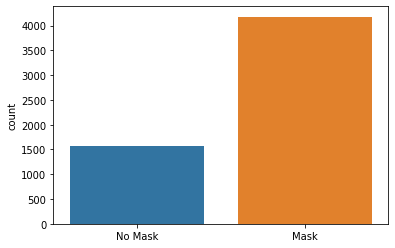

In [25]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [26]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

In [27]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [28]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#model.summary()

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

### Training the model

In [32]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=5,
                    verbose=1,
                    validation_data=(xval, yval))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
143/143 [==============================] - 932s 6s/step - loss: 0.6193 - accuracy: 0.7635 - val_loss: 0.3303 - val_accuracy: 0.8643
Epoch 2/5
143/143 [==============================] - 906s 6s/step - loss: 0.3179 - accuracy: 0.8542 - val_loss: 0.2644 - val_accuracy: 0.8948
Epoch 3/5
143/143 [==============================] - 899s 6s/step - loss: 0.3175 - accuracy: 0.8686 - val_loss: 0.2411 - val_accuracy: 0.9148
Epoch 4/5
143/143 [==============================] - 896s 6s/step - loss: 0.3018 - accuracy: 0.8733 - val_loss: 0.2322 - val_accuracy: 0.9130
Epoch 5/5
143/143 [==============================] - 903s 6s/step - loss: 0.3039 - accuracy: 0.8779 - val_loss: 0.2159 - val_accuracy: 0.9096


### Plot the statistical graph of training and validation accuracy

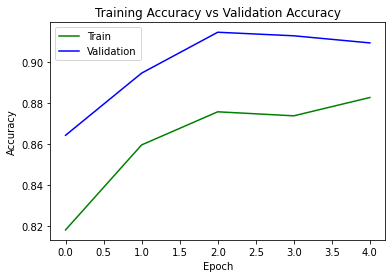

In [33]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the statistics of Training and Validation Loss

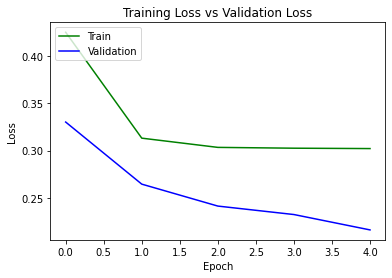

In [34]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Testing phase

In [48]:
test_images = ['1236.jpg','1330.jpg', '0745.jpg','1949.jpg','3504.png','0240.jpg']

6it [00:02,  2.65it/s]


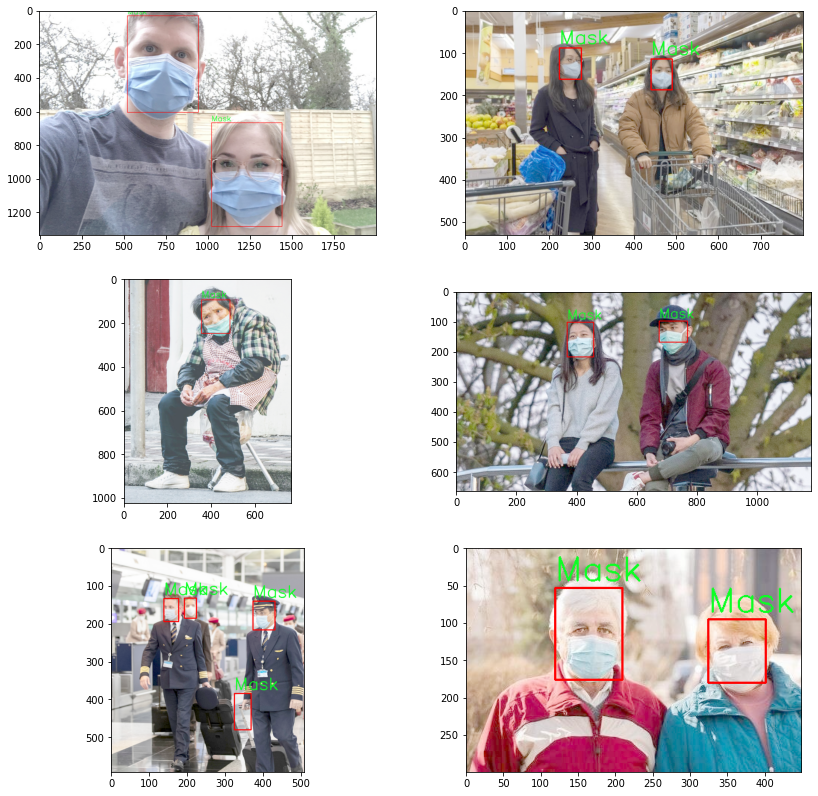

In [49]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in tqdm(enumerate(test_images)):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()